In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unet
import tensorflow as tf
from typing import Tuple, List
from PIL import Image
from numpy import asarray
from skimage.transform import resize

In [195]:
IMAGE_SIZE = (512, 512)
channels = 1 #grayscale
classes = 2

In [196]:
DATASET_PATH = "/Users/jiehyun/kaggle/"
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = DATASET_PATH + "input/hubmap-organ-segmentation/train_images"
MASK_DATASET_PATH = DATASET_PATH + "input/hubmap-organ-segmentation/binary_masks"
TRAIN_CSV = DATASET_PATH + "input/hubmap-organ-segmentation/train.csv"
train_df = pd.read_csv(TRAIN_CSV)
TOTAL_NUM_DATA = 351

In [210]:
output_shape = (512, 512)

img = Image.open(IMAGE_DATASET_PATH + '/62.tiff') #.convert('L')
img = img.resize(output_shape)
loadedimages = asarray(img)
np.save('image_test.npy', loadedimages)


masks = Image.open(MASK_DATASET_PATH + '/62.png')
masks = masks.resize(output_shape)
loadedmasks = asarray(masks)
#np.save('mask.npy', loadedmasks)


In [206]:
loadedimages

array([[[244, 245, 245],
        [245, 245, 244],
        [244, 245, 244],
        ...,
        [245, 244, 244],
        [245, 244, 243],
        [244, 244, 244]],

       [[245, 244, 244],
        [244, 245, 244],
        [244, 245, 244],
        ...,
        [244, 245, 244],
        [244, 245, 244],
        [244, 244, 244]],

       [[243, 244, 243],
        [245, 244, 244],
        [245, 245, 244],
        ...,
        [244, 244, 244],
        [244, 245, 244],
        [244, 244, 244]],

       ...,

       [[245, 245, 244],
        [245, 245, 244],
        [245, 245, 244],
        ...,
        [245, 245, 244],
        [245, 245, 244],
        [245, 245, 244]],

       [[245, 245, 244],
        [245, 245, 244],
        [245, 245, 244],
        ...,
        [245, 245, 244],
        [245, 245, 244],
        [245, 245, 244]],

       [[245, 245, 244],
        [244, 245, 244],
        [245, 245, 244],
        ...,
        [245, 245, 244],
        [245, 245, 244],
        [245, 245, 244]]

In [207]:
loadedmasks

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [208]:
loadedimages.shape

(512, 512, 3)

In [209]:
loadedmasks.shape

(512, 512)

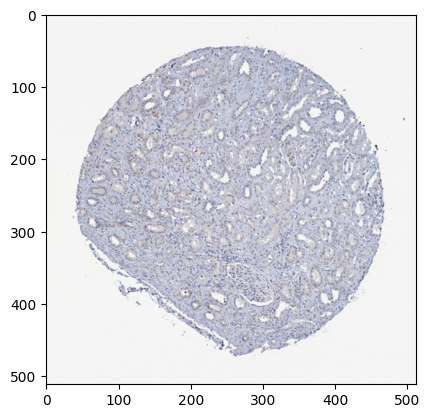

In [213]:
plt.imshow(loadedimages)
plt.show()

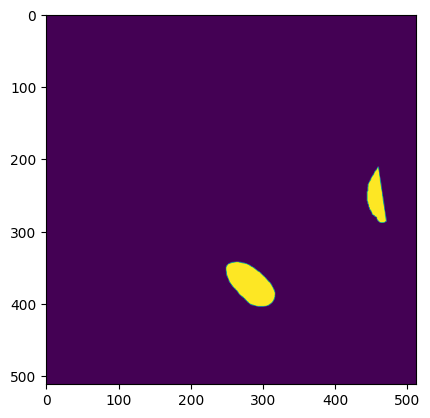

In [214]:
plt.imshow(loadedmasks)

In [211]:
def load_data(count:int, splits:Tuple[float]=(0.71, 0.145, 0.145), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs)) for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    #loaded = np.load('mito.npz')
    #loadedimages = loaded['arr_0'][0].copy()
    #loadedmasks = loaded['arr_0'][1].copy()
    
    #loaded = np.load('img_npz.npy')
    #loadedimages = loaded[0].copy()
    loadedimages = np.load('image_test.npy')
    loadedmasks = np.load('mask.npy')
    '''
    for i in range(len(train_df['id'])):
        idx = random.randint(0, len(train_df) - 1)
        img_id = train_df['id'][idx]
        loadedimages = os.path.join(DATASET_PATH, f'train_images/{img_id}.tiff')
        loadedmasks = os.path.join(DATASET_PATH, f'binary_masks/{img_id}.png')
    
    output_shape = (512, 512)

    img = Image.open(IMAGE_DATASET_PATH + '/62.tiff').convert('L')
    img = img.resize(output_shape)
    loadedimages = asarray(img)
    np.save('image.npy', loadedimages)
    loadedimages = 'image.npy'

    masks = Image.open(MASK_DATASET_PATH + '/62.png')
    masks = masks.resize(output_shape)
    loadedmasks = asarray(masks)
    np.save('mask.npy', loadedmasks)
    loadedmasks = 'mask.npy'
    '''
    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]
        #image, mask = loadedimages, loadedmasks

        #image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
        #.astype(np.float)
        #mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        image = tf.cast(image, tf.float32)/255.0
        mask -= 1
        #
        # Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)
        #
        # Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)
        #
        # Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:
            image = tf.image.rot90(image, k=1, name=None)
            mask = tf.image.rot90(mask, k=1, name=None)
        
        # augmentation done, let's store the image
        images[i] = image
        #images = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

        #images.flags.writeable = True
        #labels.flags.writeable = True

    return images, labels

In [212]:
train, val, test = load_data(TOTAL_NUM_DATA, splits=(0.71, 0.145, 0.145))

ValueError: 'image' (shape (512, 3)) must be at least three-dimensional.

In [ ]:
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [ ]:
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

trainer.fit(unet_model,
            train,
            val,
            epochs=50,
            batch_size=10
            )


In [ ]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

In [ ]:
print(prediction[0].shape)

In [ ]:
print(unet_model.summary())